In [1]:
import numpy as np
import h5py
import trimesh
import matplotlib.pyplot as plt
from random import random, uniform
import dlib
from scipy.optimize import lsq_linear

/home/hao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%run optimizers/gradient_descent.ipynb
%run initializers/pose_parameters.ipynb
%run initializers/shape_parameters.ipynb
%run features/basel_features/index_loader.ipynb
%run features/image_features/feature_extractor.ipynb
%run visualizers/model_mesh.ipynb
%run transformations/transformations.ipynb

Using TensorFlow backend.


In [3]:
class Face3DMM:
    """
    Face 3D Model Mesh construction from 2D image.
    """
    
    def __init__(self, basel_model_filepath, basel_feature_points_path, dlib_shape_predictor_filepath):
        """
        Initialize the Face3DMM constructor.
        
        Args:
          basel_model_filepath: the path to the basel model
          basel_feature_points_path: the path to the csv file containing the dlib to model points mapping
          dlib_shape_predictor_filepath: the path to the dlib predictor data model
        """
        
        # store dlib predictor path
        self.dlib_shape_predictor_filepath = dlib_shape_predictor_filepath
        
        # load the basel model
        model = h5py.File(basel_model_filepath, 'r')
        
        # load all of the shape and expression data
        self.shape_mean = np.array(model['shape']['model']['mean']) + np.array(model['expression']['model']['mean'])
        self.shape_pcaBasis = np.concatenate(
            [np.array(model['shape']['model']['pcaBasis']), np.array(model['expression']['model']['pcaBasis'])],
            axis=-1
        )
        self.shape_pcaVariance = np.concatenate(
            [np.array(model['shape']['model']['pcaVariance']), np.array(model['expression']['model']['pcaVariance'])],
            axis=-1
        )
        
        # get indexes of model feature points and associated dlib feature point numbers, indexed at 1
        feature_point_indexes, self.dlib_points = get_feature_point_indexes(basel_feature_points_path)
        
        # extract only the feature points
        self.shape_mean_features = self.shape_mean[feature_point_indexes]
        self.shape_pcaBasis_features = self.shape_pcaBasis[feature_point_indexes]
        
        # get the triangles for the model mesh
        self.triangles = np.array(model['shape']['representer']['cells'])
        
        # the number of points, features and components
        self.num_points = int(len(self.shape_mean)/3)
        self.num_features = int(len(feature_point_indexes)/3)
        self.num_components = len(self.shape_pcaVariance)
        
        # reshape the components for matrix operations
        self.shape_mean = self.shape_mean.reshape(self.shape_mean.shape+(1,))
        self.shape_mean_features = self.shape_mean_features.reshape(self.shape_mean_features.shape+(1,))
        self.shape_pcaVariance = self.shape_pcaVariance.reshape(self.shape_pcaVariance.shape+(1,))
    
    
    def get_3DMM(self, image_path):
        """
        Gets a 3DMM for an image of a face.
        
        Args:
          image_path: the path to the image of a face
        
        Returns:
          A 3DMM for the face in the 2D image
        """
        
        # extract the dlib features
        dlib_features = extract_features(image_path, self.dlib_shape_predictor_filepath, self.dlib_points)
        
        # find optimal parameters
        a, r, t, s = self.optimize(dlib_features, i=0, j=5000)
        
        # construct and return the model mesh as a trimesh object
        return self.get_model_mesh(a)
    
    
    def optimize(self, target_features, i=25, j=1000):
        """
        Gets optimal weights for a 3DMM reconstruction from the 2D input features.
        
        Args:
          target_features: the 2D target features [x1, y1, x2, y2, ...]            (2*f,1)
          i: the number of additional iterations for pose and shape estimations
          j: the number of optimizer iterations
          where
            f: the number of features
        
        Returns:
          Optimal weights for a 3DMM face reconstruction and SOP parameters (a, r, t, s)
        """
        
        # initial pose and shape parameters
        ri, ti, si = initialize_pose_parameters(target_features, np.zeros((self.num_components,1)), self.shape_mean_features, self.shape_pcaBasis_features)
        ai = initialize_shape_parameters(target_features, self.shape_mean_features, self.shape_pcaBasis_features, self.shape_pcaVariance, ri, ti, si)
        for _ in range(i):
            ri, ti, si = initialize_pose_parameters(target_features, ai, self.shape_mean_features, self.shape_pcaBasis_features)
            ai = initialize_shape_parameters(target_features, self.shape_mean_features, self.shape_pcaBasis_features, self.shape_pcaVariance, ri, ti, si)
        
        # return the result of the optimization
        return gradient_descent(
            target_features,
            self.shape_mean_features,
            self.shape_pcaBasis_features,
            self.shape_pcaVariance,
            ai,
            ri,
            ti,
            si,
            optimizer='adam',
            num_iterations=j)
    
    
    def get_projection_points(self, a, r=np.array([[1,0,0],[0,1,0],[0,0,1]]), t=np.array([0,0]).reshape(2,1), s=1., mode='all'):
        """
        Gets the 2D projections from the pca model weights.
        
        Args:
          a: the pca model weights        (c, 1)
          r: the rotation matrix          (3, 3)
          t: the translation matrix       (2, 1)
          s: the scale matrix             (1)
          mode: 'all' or 'features'
          where
            f: the number of features
            c: the number of components
        
        Returns:
          The 2D point projections         (2, n)
        """
        
        if mode.lower() == 'all':
            return project_2d(self.shape_mean, self.shape_pcaBasis, a, r, t, s)
        elif mode.lower() == 'features':
            return project_2d(self.shape_mean_features, self.shape_pcaBasis_features, a, r, t, s)
        else:
            raise Exception('model must be all or features')
            
    
    def get_model_mesh(self, a):
        """
        Gets a Trimesh object for the model mesh from the pca component weights
        
        Args:
          a: the pca model weights        (c, 1)
          where
            c: the number of components
        
        Returns:
          A Trimesh object for the model mesh
        """
        
        return get_model_mesh(model_point_combination(self.shape_mean, self.shape_pcaBasis, a), self.triangles)
    

In [7]:
x = Face3DMM(basel_model_filepath='../basel/model2017-1_bfm_nomouth.h5',
             basel_feature_points_path='./features/basel_features/feature_points.csv',
            dlib_shape_predictor_filepath='./features/image_features/dlib/shape_predictor_68_face_landmarks.dat-1')
mesh = x.get_3DMM('./test_images/test_image_2.jpeg')
mesh.show()

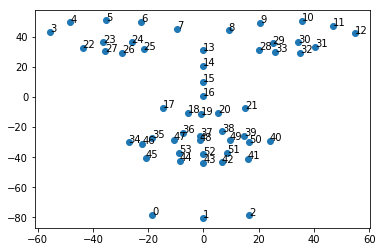

In [78]:
points = x.get_projection_points(np.array([0 for _ in range(x.num_components)]).reshape((x.num_components, 1)), mode='features')
fig, ax = plt.subplots()
ax.scatter(points[0,:], points[1,:])

for i in range(points.shape[-1]):
    ax.annotate(i, (points[0,:][i], points[1,:][i]))